# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; 
# add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/home/shashi/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# data size
azdias.shape,customers.shape

((200000, 366), (191652, 369))

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## data preprocessing and cleaning

In [6]:
#analyze number of missing values in the azdias dataset

sorted_azdias_null_values = azdias.isna().sum().sort_values()
sorted_azdias_null_values = sorted_azdias_null_values.iloc[-100:] # plotting only top 100 feature/columns

<ipython-input-7-a8b90642d010>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_azdias_null_values.index, rotation=90, ha='center')


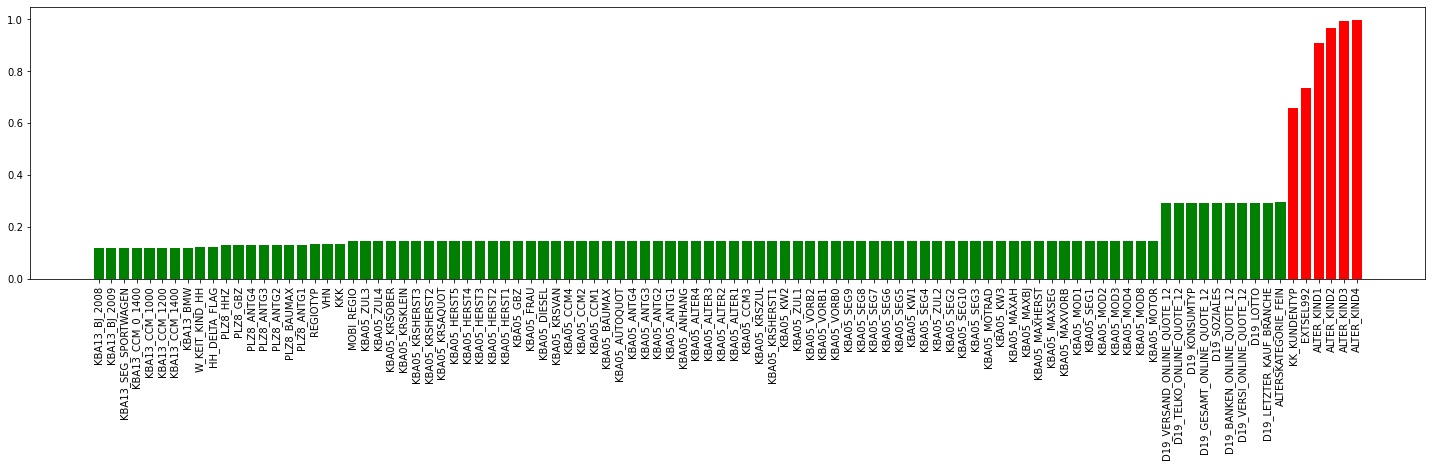

In [7]:
#plot azdias
f, ax = plt.subplots(figsize=(25,5))
gt90 = sorted_azdias_null_values.values/azdias.shape[0] >= 0.5
lt90 = sorted_azdias_null_values.values/azdias.shape[0] < 0.5
plt.bar(sorted_azdias_null_values.index[lt90], sorted_azdias_null_values.values[lt90]/azdias.shape[0], color='green')
plt.bar(sorted_azdias_null_values.index[gt90], sorted_azdias_null_values.values[gt90]/azdias.shape[0], color='red')
ax.set_xticklabels(sorted_azdias_null_values.index, rotation=90, ha='center')
plt.show()

In [8]:
#since > 50% of the entries in columns 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP' is null, hence dropping these column
columns_to_drop = list(azdias.columns[azdias.isna().sum()/azdias.shape[0] > 0.5])
columns_to_drop

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [9]:
corr = azdias.corr()

In [10]:
def find_min_max_corr(corr):
    """
        Find Min & Max correlation between each features
    """
    df_list = []
    features_done = []
    for c in corr:
        max_ = 0
        max_i = 0
        min_i = 0
        min_ = 0
        for i in corr[c].index: 
            if i != c and i not in features_done:
                #print(" test ", corr[c].index)
                if corr[c][i] > max_:
                    max_ = corr[c][i]
                    max_i = i
                if corr[c][i] < min_:
                    min_ = corr[c][i]
                    min_i = i
        df_list.append([c,min_i, min_, max_i, max_])
        features_done.append(c)
    return pd.DataFrame(df_list, columns=["Features", "min", "min_value", "max", "max_value"])

corr_min_max = find_min_max_corr(corr)

In [11]:
corr_min_max.sort_values(by="min_value")[["Features", "min", "min_value"]].iloc[:10]

,Features,min,min_value
107,GEMEINDETYP,ORTSGR_KLS9,-0.934333
49,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,-0.870536
46,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,-0.869398
80,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,-0.868846
77,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,-0.863271
285,KBA13_SITZE_4,KBA13_SITZE_5,-0.862001
32,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,-0.851564
297,KOMBIALTER,PRAEGENDE_JUGENDJAHRE,-0.834707
84,D19_VERSI_ANZ_24,D19_VERSI_DATUM,-0.833371
45,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,-0.825516


In [12]:
corr_min_max.sort_values(by="max_value", ascending=False)[["Features", "max", "max_value"]].iloc[:10]

,Features,max,max_value
212,KBA13_FAB_SONSTIGE,KBA13_HERST_SONST,1.000000
302,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,0.990015
300,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,0.984015
304,LP_STATUS_FEIN,LP_STATUS_GROB,0.982314
9,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,0.981293
215,KBA13_GBZ,PLZ8_GBZ,0.979833
233,KBA13_HHZ,PLZ8_HHZ,0.968350
240,KBA13_KMH_211,KBA13_KMH_250,0.958985
78,D19_VERSAND_DATUM,D19_VERSAND_ONLINE_DATUM,0.958030
301,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,0.957106


In [13]:
azdias[['EINGEFUEGT_AM']].head()

,EINGEFUEGT_AM
0,NaN
1,1992-02-10 00:00:00
2,1992-02-12 00:00:00
3,1997-04-21 00:00:00
4,1992-02-12 00:00:00


In [14]:
azdias[['EINGEFUEGT_AM']].describe()

,EINGEFUEGT_AM
count,179127
unique,3521
top,1992-02-10 00:00:00
freq,86400


In [15]:
# EINGEFUEGT_AM is present as timestamp 
# converting it to Year to be used while doing feature encoding
def getYearFromTimeStamp(df):
    """
        Input: df-> Series with values as str
        Convert values to TimeStamp
        extract year from timestamp
        return year in str format
    """
    return pd.to_datetime(df).apply(lambda x:x.year).astype('str')

azdias['EINGEFUEGT_AM'] = getYearFromTimeStamp(azdias['EINGEFUEGT_AM'])
customers['EINGEFUEGT_AM'] = getYearFromTimeStamp(customers['EINGEFUEGT_AM'])

In [16]:
azdias[['EINGEFUEGT_AM']].head()

,EINGEFUEGT_AM
0,nan
1,1992.0
2,1992.0
3,1997.0
4,1992.0


In [17]:
azdias[['EINGEFUEGT_AM']].describe()

,EINGEFUEGT_AM
count,200000
unique,27
top,1992.0
freq,131653


In [18]:
#data cleaning

In [19]:
#columns_to_drop = list(azdias.columns[azdias.isna().sum()/azdias.shape[0] > 0.5])
def drop_columns(df, columns=columns_to_drop):
    """
        Remove columns from df
        Input:
            df : Pandas Dataframe Object
            columns: columns to be deleted
    """
    df.drop(columns, axis=1, inplace=True)
    return
#drop ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','EXTSEL992','KK_KUNDENTYP'
drop_columns(customers)
drop_columns(azdias)

In [20]:
#scale
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [21]:
def get_cat_columns(df):
    '''
        Identify columns with category/object dtype
        Input:
            df: pandas Dataframe
        retrun:
            category_col(dtyep = object), rest_col(dtype = int/float)
    '''
    category_col = list()
    rest_col = list()
    for col in df:
        if df[col].dtype == 'object':
            category_col.append(col)
        else:
            rest_col.append(col)
    return category_col, rest_col

def fill(df, strategy):
    if strategy == 'mean':
        df = df.fillna(df.mean())
    elif strategy == 'mode':
        df = df.fillna(df.mode().loc[0])
    return df

def fill_missing_values(df):
    """
        Fill the missing value
        split dataframe into 2 parts, object and non-object dtypes
        perform mean and median Imputation respectively
        return new dataframe with filled values, 
        NOTE: Preserve columm order
        
        Input:
            df: Pandas Dataframe with null values
        Retrun:
            new_df: dataframe with filled values
    """
    initial_col_order = df.columns
    object_col, rest_col = get_cat_columns(df)
    df1 = fill(df[rest_col], 'mean')
    df2 = fill(df[object_col], 'mode')
    new_df = pd.concat([df1, df2], axis=1)
    return new_df[initial_col_order]

In [22]:
azdias = fill_missing_values(azdias)
customers = fill_missing_values(customers)

In [23]:
# get_cat_columns(azdias)
#set(azdias['EINGEFUEGT_AM']) - set(customers['EINGEFUEGT_AM'])
# azdias.shape, customers.shape

In [24]:
#encode category val
def encode(df, encoder=None):
    """
        encode
    """
    if not encoder:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoded_values = encoder.fit_transform(df.astype('str')).toarray()
    else:
        encoded_values = encoder.transform(df.astype('str')).toarray()
    return pd.DataFrame(data=encoded_values, columns=encoder.get_feature_names_out(df.columns)), encoder

def scale(df, scale=None):
    """
        Perform scaling for all the coluns present in dataframe.
        Scaled values will be between -1 and 1
    """
    if not scale:
        scale = MinMaxScaler()
        scaled_data = scale.fit_transform(df)
    else:
        scaled_data = scale.transform(df)
    return pd.DataFrame(data=scaled_data, columns=df.columns), scale

def get_encoded_and_scaled_values(df, scale_=None, encoder_=None):
    """
        Split dataframe into 2 parts, category and non-categorical
        encode catgorical values
        merge both parts
    """
    category_col, rest_col = get_cat_columns(df)
    encoded_df, encoder_ = encode(df[category_col], encoder_)
    scaled_df, scale_ = scale(df[rest_col], scale_)
    new_df = pd.concat((encoded_df, scaled_df), axis = 1)
    return new_df, scale_, encoder_

In [25]:
#drop 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP' while encoding since these are not present in azdias
# customers[['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']]

In [26]:
azdias_encoded, scale_, encoder_ = get_encoded_and_scaled_values(azdias)
customers_encoded, scale_, encoder_ = get_encoded_and_scaled_values(\
    customers.drop(['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1), scale_, encoder_)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**Converting dimension of 891211 x 366  dataset to 891211 x 2 to get some visual insight from the data**

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca1 = PCA(n_components=2)
azdias_reduced = pca1.fit_transform(azdias_encoded)

In [19]:
pca2 = PCA(n_components=2)
customers_reduced = pca2.fit_transform(customers_encoded)

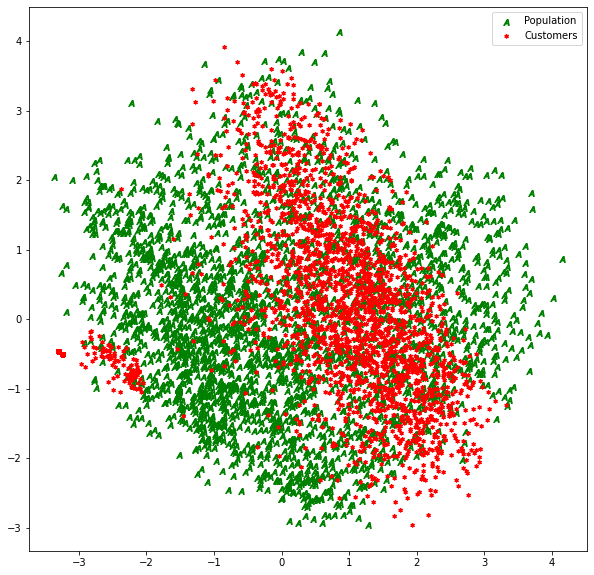

In [29]:
#pick random index
f, ax = plt.subplots(figsize=(10,10))
random_index_azdias = np.random.randint(0, azdias_encoded.shape[0], size=3000)
random_index_customers = np.random.randint(0, customers_encoded.shape[0], size=3000)
plt.scatter(azdias_reduced[random_index_azdias, 0], azdias_reduced[random_index_azdias, 1], marker='$A$', c='green', label="Population")
plt.scatter(customers_reduced[random_index_customers, 0], customers_reduced[random_index_customers, 1], marker='$*$', c='red', label="Customers")
ax.legend()

plt.savefig('pcaoutput.png', bbox_inches='tight')

### Calulate similarity between the customers and general population 

In [30]:
import progressbar

def find_similarity(user, customers=customers_encoded):
    """
        Calaulate average similarity of user with
        existing customers
    """
    score = 0
    dot_product = np.dot(user.values, customers_encoded.values.T)
    score = np.sum(dot_product, axis=1)
    return score/customers.shape[0]
    
def find_customers_in_users(df=azdias_encoded, customers=customers_encoded):
    """
        Iterate on customers_encoded
        find the similarity score(dot product)
        identify threshhold similarity above which a user from azdias can be considered to be a patential customer 
    """
    batch_size = 500
    bar = progressbar.ProgressBar(maxval=(df.shape[0]//batch_size + 1))
    bar.start()
    score = np.zeros(df.shape[0])
    done = False
    i = 0 
    while not done:
        a, f = (batch_size*i), ((i+1)*batch_size) if ((i+1)*batch_size)<df.shape[0] else df.shape[0]
        score[a:(f+1)]= find_similarity(df.loc[a:f], customers)
        try:
            bar.update(i)
        except:
            print("Error updating progressbar")
        i += 1;
        if (i * batch_size) >= df.shape[0]:
            done = True
    bar.finish()
    return score

In [31]:
similarity_score = find_customers_in_users()

100% (401 of 401) |######################| Elapsed Time: 1:09:53 Time:  1:09:53


In [32]:
azdias_encoded['similarity_score'] = similarity_score

In [33]:
azdias_encoded.sort_values(by='similarity_score', ascending=False, inplace=True)

In [38]:
azdias_encoded['similarity_score']

156126    90.872988
24741     90.660201
184704    90.650862
167290    90.343044
48506     90.134728
            ...    
169353    54.829851
83743     54.131386
183967    53.802859
113733    50.017819
187566    49.640377
Name: similarity_score, Length: 200000, dtype: float64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [48]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/shashi/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


**Data Preprocessing-> using similar methods and encoder used for processing azdias data**

In [50]:
def processData(df, scale_=scale_, encoder_=encoder_, test= False):
    """
        Perform data preprocessing
        using similar flow and encoder used for processing azdias and customers data
        Input:
            df: mailout_data
            scale_ : scale to be used for minmax scaling
            encoder_ :  encoder to be used for onehot encoding
        Output:
            
            X(processed Features variables), y (target variable)
    """
    #drop ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','EXTSEL992','KK_KUNDENTYP'
    drop_columns(df)
    df['EINGEFUEGT_AM'] = getYearFromTimeStamp(df['EINGEFUEGT_AM'])
    #X - Features variables, y - target variable
    if not test:
        X, y = df.drop(labels=["RESPONSE"], axis=1), mailout_train["RESPONSE"]
    else:
        X = df
        y = None
    X = fill_missing_values(X)
    X, scale_, encoder = get_encoded_and_scaled_values(X, scale_, encoder_)
    return X, y

In [51]:
X, y = processData(mailout_train)

In [52]:
sum(y == 0)/y.shape[0] , sum(y == 1)/y.shape[0]

(0.9876169638284996, 0.012383036171500396)

**Splitting data into train and test data and train model**

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [57]:
model.score(X_test, y_test)

0.9696264401256837

In [58]:
from sklearn.metrics import confusion_matrix, f1_score

In [59]:
confusion_matrix(model.predict(X_test), y_test)

array([[8328,  117],
       [ 144,    4]])

In [60]:
f1_score(model.predict(X_test), y_test)

0.029739776951672865

**Oversampling to fix unbalanced target values**

In [61]:
from imblearn.over_sampling import RandomOverSampler

In [62]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

**Target Values distibution post oversampling**

In [63]:
sum(y_over == 0)/y_over.shape[0] , sum(y_over == 1)/y_over.shape[0]

(0.5, 0.5)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [65]:
confusion_matrix(model.predict(X_test), y_test)

array([[8399, 1870],
       [  41, 6662]])

In [66]:
f1_score(model.predict(X_test), y_test)

0.8745651460452905

## Part 3: Kaggle Competition
   Predictions on data: Udacity_MAILOUT_052018_TEST.csv will be submitted to kaggle competition

In [67]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv',  sep=';')

/home/shashi/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [68]:
X, y = processData(mailout_test, test=True)
predictions = model.predict(X)

In [69]:
#predictions
submission = pd.DataFrame(predictions, index=mailout_test['LNR'].astype('int32'), columns=["RESPONSE"])
submission.head()

,RESPONSE
LNR,
1754,1
1770,0
1465,0
1470,0
1478,0


In [70]:
#create fine to sumbit
submission.to_csv('submission.csv')